In [1]:
# ============================================================================
# Aureus Sigma Capital - Production Strategy Backtest (v1.2 - Corrected)
# Notebook: 11_production_strategy_backtest_v1.2.ipynb
#
# Description:
# This notebook implements and validates the FINAL, production-ready "v1.2"
# strategies. It uses the CORRECTED backtesting engine that implements the
# proper "filter-then-rank" methodology:
#   1. ADTV-based liquidity filtering is applied FIRST.
#   2. Factor ranking and selection is performed ONLY on the liquid universe.
#
# This notebook serves as the CANONICAL SOURCE for the final performance
# metrics of our official product suite, superseding the flawed v1.1 results.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 28, 2025
# Version: 1.2 - Corrected Production-Ready Engine
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import yaml
from sqlalchemy import create_engine, text
from tqdm import tqdm

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
STRATEGY_COLORS = {
    'Benchmark': '#34495E',
    'Aggressive Growth v1.2': '#E74C3C',
    'Balanced Growth v1.2': '#F39C12',
    'Risk-Managed Institutional v1.2': '#16A085',
    'Positive': '#27AE60', 'Negative': '#C0392B', 'Drawdown': '#E67E22',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50'
}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': STRATEGY_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': STRATEGY_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': STRATEGY_COLORS['Text_Primary'],
    'grid.color': STRATEGY_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': STRATEGY_COLORS['Text_Primary'], 'ytick.color': STRATEGY_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Visualization environment configured.")

# --- v1.2 PRODUCTION STRATEGY CONFIGURATION ---
PRODUCTION_CONFIG_V1_2 = {
    "rebalance_freq": 'Q',
    "liquidity_threshold_vnd": 10_000_000_000, # 10B VND (Validated in Notebook 10)
    "adtv_lookback_days": 63, # 3 months
    "selection_method": 'fixed_number',
    "portfolio_size": 25,
    "weighting_method": 'equal',
    "max_sector_weight": 0.40,
    "max_position_weight": 0.08, # 8% cap
    "transaction_cost_bps": 30
}

# --- ANALYSIS PERIOD ---
ANALYSIS_START_DATE = "2018-01-01"
ANALYSIS_END_DATE = "2025-07-25"

print("\n" + "=" * 70)
print("🏆 Aureus Sigma: Production Strategy Backtest (v1.2 - Corrected)")
print("=" * 70)
print("\n🔬 Production Configuration (v1.2):")
for key, value in PRODUCTION_CONFIG_V1_2.items():
    if "vnd" in key:
        print(f"   - {key:<25}: {value:,.0f} VND")
    else:
        print(f"   - {key:<25}: {value}")
print("-" * 70)

📊 Visualization environment configured.

🏆 Aureus Sigma: Production Strategy Backtest (v1.2 - Corrected)

🔬 Production Configuration (v1.2):
   - rebalance_freq           : Q
   - liquidity_threshold_vnd  : 10,000,000,000 VND
   - adtv_lookback_days       : 63
   - selection_method         : fixed_number
   - portfolio_size           : 25
   - weighting_method         : equal
   - max_sector_weight        : 0.4
   - max_position_weight      : 0.08
   - transaction_cost_bps     : 30
----------------------------------------------------------------------


In [3]:
# ============================================================================
# CELL 2: THE CORRECTED PRODUCTION-READY BACKTESTING ENGINE (v1.2)
# ============================================================================

print("🔧 Defining the CORRECTED production-ready backtesting engine (v1.2)...")
print("   - FIX: Applies liquidity filter BEFORE ranking to preserve alpha.")

# --- Helper Function: Portfolio Construction (v1.1 logic is correct here) ---
def construct_constrained_portfolio_v1_1(
    factor_scores: pd.Series, 
    sector_info: pd.DataFrame, 
    config: dict
) -> pd.DataFrame:
    """
    Constructs a portfolio from a pre-filtered list of liquid, high-scoring stocks.
    """
    if factor_scores.empty: return pd.DataFrame()

    # Step 1: Stock Selection (Fixed Number)
    selected_stocks_df = factor_scores.nlargest(config['portfolio_size']).to_frame('factor_score')
    
    portfolio_df = selected_stocks_df.join(sector_info).dropna(subset=['sector'])
    if portfolio_df.empty: return pd.DataFrame()

    # Step 2: Sector Constraint Application
    sector_counts = portfolio_df['sector'].value_counts()
    max_stocks_per_sector = int(config['portfolio_size'] * config['max_sector_weight'])
    final_tickers = set()
    for sector, count in sector_counts.items():
        sector_stocks = portfolio_df[portfolio_df['sector'] == sector]
        if count > max_stocks_per_sector > 0:
            final_tickers.update(sector_stocks.nlargest(max_stocks_per_sector, 'factor_score').index)
        else:
            final_tickers.update(sector_stocks.index)
    
    final_portfolio = portfolio_df.loc[list(final_tickers)].copy()
    if final_portfolio.empty: return pd.DataFrame()

    # Step 3: Weighting
    if config['weighting_method'] == 'equal':
        final_portfolio['weight'] = 1.0 / len(final_portfolio)
    
    final_portfolio['weight'] = final_portfolio['weight'].clip(upper=config['max_position_weight'])
    final_portfolio['weight'] /= final_portfolio['weight'].sum()
    
    return final_portfolio

# --- Master Backtesting Function (Corrected v1.2) ---
def run_detailed_backtest_v1_2(
    strategy_name: str,
    risk_factor: float,
    base_config: dict,
    factor_data: dict,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    market_regimes: pd.DataFrame,
    adtv_data: pd.DataFrame
) -> Dict:
    """
    Runs a full backtest using the CORRECTED v1.2 logic where the liquidity
    filter is applied BEFORE ranking.
    """
    print(f"\n--- Running v1.2 backtest for: {strategy_name} (Risk Factor: {risk_factor}) ---")
    
    config = base_config.copy()
    
    # Prepare "As-Of" Data
    rebalance_dates = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq=config['rebalance_freq'])
    regimes_on_rebal_dates = market_regimes.reindex(rebalance_dates, method='ffill')
    q_scores_on_rebal_dates = factor_data['quality'].reindex(rebalance_dates, method='ffill')
    v_scores_on_rebal_dates = factor_data['value'].reindex(rebalance_dates, method='ffill')
    m_scores_on_rebal_dates = factor_data['momentum'].reindex(rebalance_dates, method='ffill')
    adtv_on_rebal_dates = adtv_data.reindex(rebalance_dates, method='ffill')
    print("   - 'As-of' lookup tables created.")

    # Portfolio Construction Loop
    portfolios = {}
    universe_size_log = {}
    for date in tqdm(rebalance_dates, desc=f"Constructing Portfolios for {strategy_name}"):
        regime = regimes_on_rebal_dates.loc[date, 'regime']
        
        # Dynamic Alpha Calculation for the FULL universe
        if regime == 'Stress':
            qvm_composite_full = (0.35 * q_scores_on_rebal_dates.loc[date]) + (0.35 * v_scores_on_rebal_dates.loc[date]) - (0.30 * m_scores_on_rebal_dates.loc[date])
        else:
            qvm_composite_full = (0.50 * q_scores_on_rebal_dates.loc[date]) + (0.50 * v_scores_on_rebal_dates.loc[date])
        
        # *** THE CRITICAL FIX: FILTER FIRST, THEN RANK/SELECT ***
        current_adtv = adtv_on_rebal_dates.loc[date]
        liquid_universe_mask = current_adtv >= config['liquidity_threshold_vnd']
        liquid_tickers = current_adtv[liquid_universe_mask].index
        universe_size_log[date] = len(liquid_tickers)
        
        liquid_qvm_scores = qvm_composite_full.loc[qvm_composite_full.index.intersection(liquid_tickers)]
        
        portfolio_df = construct_constrained_portfolio_v1_1(liquid_qvm_scores.dropna(), sector_info, config)
        
        if not portfolio_df.empty:
            portfolio_df = portfolio_df.join(q_scores_on_rebal_dates.loc[date].rename('quality_score'))
            portfolio_df = portfolio_df.join(v_scores_on_rebal_dates.loc[date].rename('value_score'))
            portfolio_df = portfolio_df.join(m_scores_on_rebal_dates.loc[date].rename('momentum_score'))
            portfolios[date] = portfolio_df

    # Generate Daily Holdings & Apply Risk Overlay
    alpha_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    for i, date in enumerate(rebalance_dates):
        if date in portfolios:
            next_date = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else daily_returns.index[-1] + pd.Timedelta(days=1)
            holding_period = daily_returns.index[(daily_returns.index > date) & (daily_returns.index < next_date)]
            portfolio = portfolios[date]
            for day in holding_period:
                alpha_holdings.loc[day, portfolio.index] = portfolio['weight']
    
    exposure_signal = pd.Series(1.0, index=market_regimes.index)
    risk_mask = market_regimes['regime'].isin(['Bear', 'Stress'])
    exposure_signal.loc[market_regimes[risk_mask].index] = risk_factor
    hybrid_holdings = alpha_holdings.mul(exposure_signal, axis=0)
    
    # Calculate Net Returns
    holdings_shifted = hybrid_holdings.shift(1).fillna(0)
    gross_returns = (holdings_shifted * daily_returns).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - transaction_costs
    
    print(f"   - Backtest complete. Average liquid universe size: {np.mean(list(universe_size_log.values())):.0f} stocks.")
    
    return {
        'name': strategy_name,
        'returns': net_returns,
        'portfolios': portfolios,
        'universe_log': universe_size_log
    }

print("✅ CORRECTED production-ready backtesting engine `run_detailed_backtest_v1_2` is defined.")

🔧 Defining the CORRECTED production-ready backtesting engine (v1.2)...
   - FIX: Applies liquidity filter BEFORE ranking to preserve alpha.
✅ CORRECTED production-ready backtesting engine `run_detailed_backtest_v1_2` is defined.


In [5]:
# ============================================================================
# Aureus Sigma Capital - Production Strategy Backtest (v1.2 - Corrected)
# Notebook: 11_production_strategy_backtest_v1.2.ipynb
#
# Description:
# This notebook implements and validates the FINAL, production-ready "v1.2"
# strategies. It uses the CORRECTED backtesting engine that implements the
# proper "filter-then-rank" methodology.
#
# This notebook serves as the CANONICAL SOURCE for the final performance
# metrics of our official product suite.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 28, 2025
# Version: 1.2 - Corrected Production-Ready Engine
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import yaml
from sqlalchemy import create_engine, text
from tqdm import tqdm
import pickle # *** THE CRITICAL FIX ***

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
STRATEGY_COLORS = {
    'Benchmark': '#34495E',
    'Aggressive Growth v1.2': '#E74C3C',
    'Balanced Growth v1.2': '#F39C12',
    'Risk-Managed Institutional v1.2': '#16A085',
    'Positive': '#27AE60', 'Negative': '#C0392B', 'Drawdown': '#E67E22',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50'
}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': STRATEGY_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': STRATEGY_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': STRATEGY_COLORS['Text_Primary'],
    'grid.color': STRATEGY_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': STRATEGY_COLORS['Text_Primary'], 'ytick.color': STRATEGY_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Visualization environment configured.")

# --- v1.2 PRODUCTION STRATEGY CONFIGURATION ---
PRODUCTION_CONFIG_V1_2 = {
    "rebalance_freq": 'Q',
    "liquidity_threshold_vnd": 10_000_000_000, # 10B VND (Validated in Notebook 10)
    "adtv_lookback_days": 63, # 3 months
    "selection_method": 'fixed_number',
    "portfolio_size": 25,
    "weighting_method": 'equal',
    "max_sector_weight": 0.40,
    "max_position_weight": 0.08, # 8% cap
    "transaction_cost_bps": 30
}

# --- ANALYSIS PERIOD ---
ANALYSIS_START_DATE = "2018-01-01"
ANALYSIS_END_DATE = "2025-07-25"

print("\n" + "=" * 70)
print("🏆 Aureus Sigma: Production Strategy Backtest (v1.2 - Corrected)")
print("=" * 70)
print("\n🔬 Production Configuration (v1.2):")
for key, value in PRODUCTION_CONFIG_V1_2.items():
    if "vnd" in key:
        print(f"   - {key:<25}: {value:,.0f} VND")
    else:
        print(f"   - {key:<25}: {value}")
print("-" * 70)

📊 Visualization environment configured.

🏆 Aureus Sigma: Production Strategy Backtest (v1.2 - Corrected)

🔬 Production Configuration (v1.2):
   - rebalance_freq           : Q
   - liquidity_threshold_vnd  : 10,000,000,000 VND
   - adtv_lookback_days       : 63
   - selection_method         : fixed_number
   - portfolio_size           : 25
   - weighting_method         : equal
   - max_sector_weight        : 0.4
   - max_position_weight      : 0.08
   - transaction_cost_bps     : 30
----------------------------------------------------------------------


In [6]:
# ============================================================================
# CELL 3: LOAD ALL REQUIRED DATA FOR v1.2 BACKTEST
# ============================================================================

print("📂 Loading all data sources required for the v1.2 backtesting engine...")

# --- Establish Paths and Database Connection ---
project_root = Path.cwd()
while not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root directory.")
    project_root = project_root.parent

phase7_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"
phase8_path = project_root / "production" / "tests" / "phase8_risk_management"

config_path = project_root / 'config' / 'database.yml'
with open(config_path, 'r') as f:
    db_config = yaml.safe_load(f)['production']
engine = create_engine(
    f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
    f"{db_config['host']}/{db_config['schema_name']}",
    pool_pre_ping=True
)

# --- 1. Load Factor Scores ---
with open(phase7_path / "factor_data.pkl", "rb") as f:
    factor_data_obj = pickle.load(f)
factor_data_full = factor_data_obj['data']
factor_scores_dict = {
    'quality': factor_data_full['quality_score'],
    'value': factor_data_full['value_score'],
    'momentum': factor_data_full['momentum_score']
}
print("   - ✅ Factor Scores loaded.")

# --- 2. Load Daily Returns ---
with open(phase7_path / "daily_returns.pkl", "rb") as f:
    returns_data_obj = pickle.load(f)
daily_returns_full = returns_data_obj['data']
print("   - ✅ Daily Returns loaded.")

# --- 3. Load Sector Info ---
sector_info_sql = "SELECT ticker, sector FROM master_info WHERE sector IS NOT NULL"
sector_info = pd.read_sql(sector_info_sql, engine).drop_duplicates(subset=['ticker']).set_index('ticker')
print(f"   - ✅ Sector Info loaded for {len(sector_info)} tickers.")

# --- 4. Load Market Regimes ---
with open(phase8_path / "phase8_results.pkl", "rb") as f:
    phase8_results = pickle.load(f)
market_regimes_full = phase8_results['market_regimes']
print("   - ✅ Market Regimes loaded.")

# --- 5. Load and Calculate ADTV Data ---
print("   - Loading raw market data to calculate ADTV...")
# Fetch data from 3 months prior to the start date to ensure the lookback window is full
adtv_start_date = pd.to_datetime(ANALYSIS_START_DATE) - pd.DateOffset(months=3)
adtv_query = text("""
    SELECT trading_date AS date, ticker, close_price_adjusted AS close, total_volume AS volume
    FROM vcsc_daily_data_complete
    WHERE trading_date BETWEEN :start_date AND :end_date;
""")
raw_market_data = pd.read_sql(adtv_query, engine, params={'start_date': adtv_start_date, 'end_date': ANALYSIS_END_DATE}, parse_dates=['date'])
engine.dispose()
print("   - Raw market data loaded. Calculating 3-Month ADTV...")

# Calculate daily turnover in VND
raw_market_data['turnover_vnd'] = raw_market_data['close'] * raw_market_data['volume']

# Pivot to have tickers as columns
turnover_pivot = raw_market_data.pivot(index='date', columns='ticker', values='turnover_vnd')

# Calculate 3-month (63-day) rolling average
adtv_lookback = PRODUCTION_CONFIG_V1_2['adtv_lookback_days']
adtv_data = turnover_pivot.rolling(window=adtv_lookback, min_periods=int(adtv_lookback * 0.8)).mean()
print(f"   - ✅ {adtv_lookback}-day rolling ADTV calculated.")

print("\n" + "=" * 80)
print("✅ All data sources are loaded and prepared. Ready to run v1.2 backtests.")
print("=" * 80)

📂 Loading all data sources required for the v1.2 backtesting engine...
   - ✅ Factor Scores loaded.
   - ✅ Daily Returns loaded.
   - ✅ Sector Info loaded for 728 tickers.
   - ✅ Market Regimes loaded.
   - Loading raw market data to calculate ADTV...
   - Raw market data loaded. Calculating 3-Month ADTV...
   - ✅ 63-day rolling ADTV calculated.

✅ All data sources are loaded and prepared. Ready to run v1.2 backtests.


In [7]:
# ============================================================================
# CELL 4: EXECUTE v1.2 BACKTESTS AND GENERATE MASTER DATA
# ============================================================================

print("🚀 Executing CORRECTED production-ready v1.2 backtests...")

# --- Product Suite Definitions ---
product_suite_definitions_v1_2 = {
    "Aggressive Growth v1.2": 0.5,
    "Balanced Growth v1.2": 0.3,
    "Risk-Managed Institutional v1.2": 0.2
}

# --- Run Backtests and Compile Master Data Object ---
master_analysis_data_v1_2 = {}

for name, risk_factor in product_suite_definitions_v1_2.items():
    strategy_results = run_detailed_backtest_v1_2(
        strategy_name=name,
        risk_factor=risk_factor,
        base_config=PRODUCTION_CONFIG_V1_2,
        factor_data=factor_scores_dict,
        daily_returns=daily_returns_full,
        sector_info=sector_info,
        market_regimes=market_regimes_full,
        adtv_data=adtv_data
    )
    master_analysis_data_v1_2[name] = strategy_results

# --- Add the Benchmark for Comparison ---
with open(phase7_path / "benchmark_returns.pkl", "rb") as f:
    benchmark_data_obj = pickle.load(f)
benchmark_returns_full = benchmark_data_obj['data']

master_analysis_data_v1_2['Benchmark'] = {
    'name': 'Benchmark',
    'returns': benchmark_returns_full,
    'portfolios': {},
    'universe_log': {}
}

print("\n" + "=" * 80)
print("✅ v1.2 Master analysis data object created successfully.")
print("   Contains detailed returns and portfolio compositions for:")
for name in master_analysis_data_v1_2.keys():
    print(f"     - {name}")
print("=" * 80)

# --- Final Step: Slice the generated data to our analysis period ---
print(f"\n🔪 Slicing v1.2 master data to the analysis period: {ANALYSIS_START_DATE} to {ANALYSIS_END_DATE}")

final_returns_data_v1_2 = {}
final_portfolios_data_v1_2 = {}

for name, data in master_analysis_data_v1_2.items():
    final_returns_data_v1_2[name] = data['returns'].loc[ANALYSIS_START_DATE:ANALYSIS_END_DATE]
    final_portfolios_data_v1_2[name] = {
        date: portfolio for date, portfolio in data['portfolios'].items()
        if pd.to_datetime(ANALYSIS_START_DATE) <= date <= pd.to_datetime(ANALYSIS_END_DATE)
    }

# Create the final, analysis-ready DataFrame of returns
returns_df_v1_2 = pd.DataFrame(final_returns_data_v1_2)

print("\n✅ All v1.2 data is now generated, correctly mapped, and sliced.")
print("   Ready for final performance analysis.")
display(returns_df_v1_2.head())

🚀 Executing CORRECTED production-ready v1.2 backtests...

--- Running v1.2 backtest for: Aggressive Growth v1.2 (Risk Factor: 0.5) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Aggressive Growth v1.2: 100%|██████████| 38/38 [00:00<00:00, 179.89it/s]


   - Backtest complete. Average liquid universe size: 106 stocks.

--- Running v1.2 backtest for: Balanced Growth v1.2 (Risk Factor: 0.3) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Balanced Growth v1.2: 100%|██████████| 38/38 [00:00<00:00, 137.72it/s]


   - Backtest complete. Average liquid universe size: 106 stocks.

--- Running v1.2 backtest for: Risk-Managed Institutional v1.2 (Risk Factor: 0.2) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Risk-Managed Institutional v1.2: 100%|██████████| 38/38 [00:00<00:00, 281.42it/s]


   - Backtest complete. Average liquid universe size: 106 stocks.

✅ v1.2 Master analysis data object created successfully.
   Contains detailed returns and portfolio compositions for:
     - Aggressive Growth v1.2
     - Balanced Growth v1.2
     - Risk-Managed Institutional v1.2
     - Benchmark

🔪 Slicing v1.2 master data to the analysis period: 2018-01-01 to 2025-07-25

✅ All v1.2 data is now generated, correctly mapped, and sliced.
   Ready for final performance analysis.


,Aggressive Growth v1.2,Balanced Growth v1.2,Risk-Managed Institutional v1.2,Benchmark
2018-01-02,0.000000,0.000000,0.000000,0.011715
2018-01-03,0.008914,0.008914,0.008914,0.009942
2018-01-04,0.016222,0.016222,0.016222,0.014001
2018-01-05,-0.006145,-0.006145,-0.006145,-0.006962
2018-01-08,0.010252,0.010252,0.010252,0.010122


📊 Generating final performance analysis for the CORRECTED v1.2 Production Strategies...
   - Performance analysis re-based to true inception date: 2018-01-03


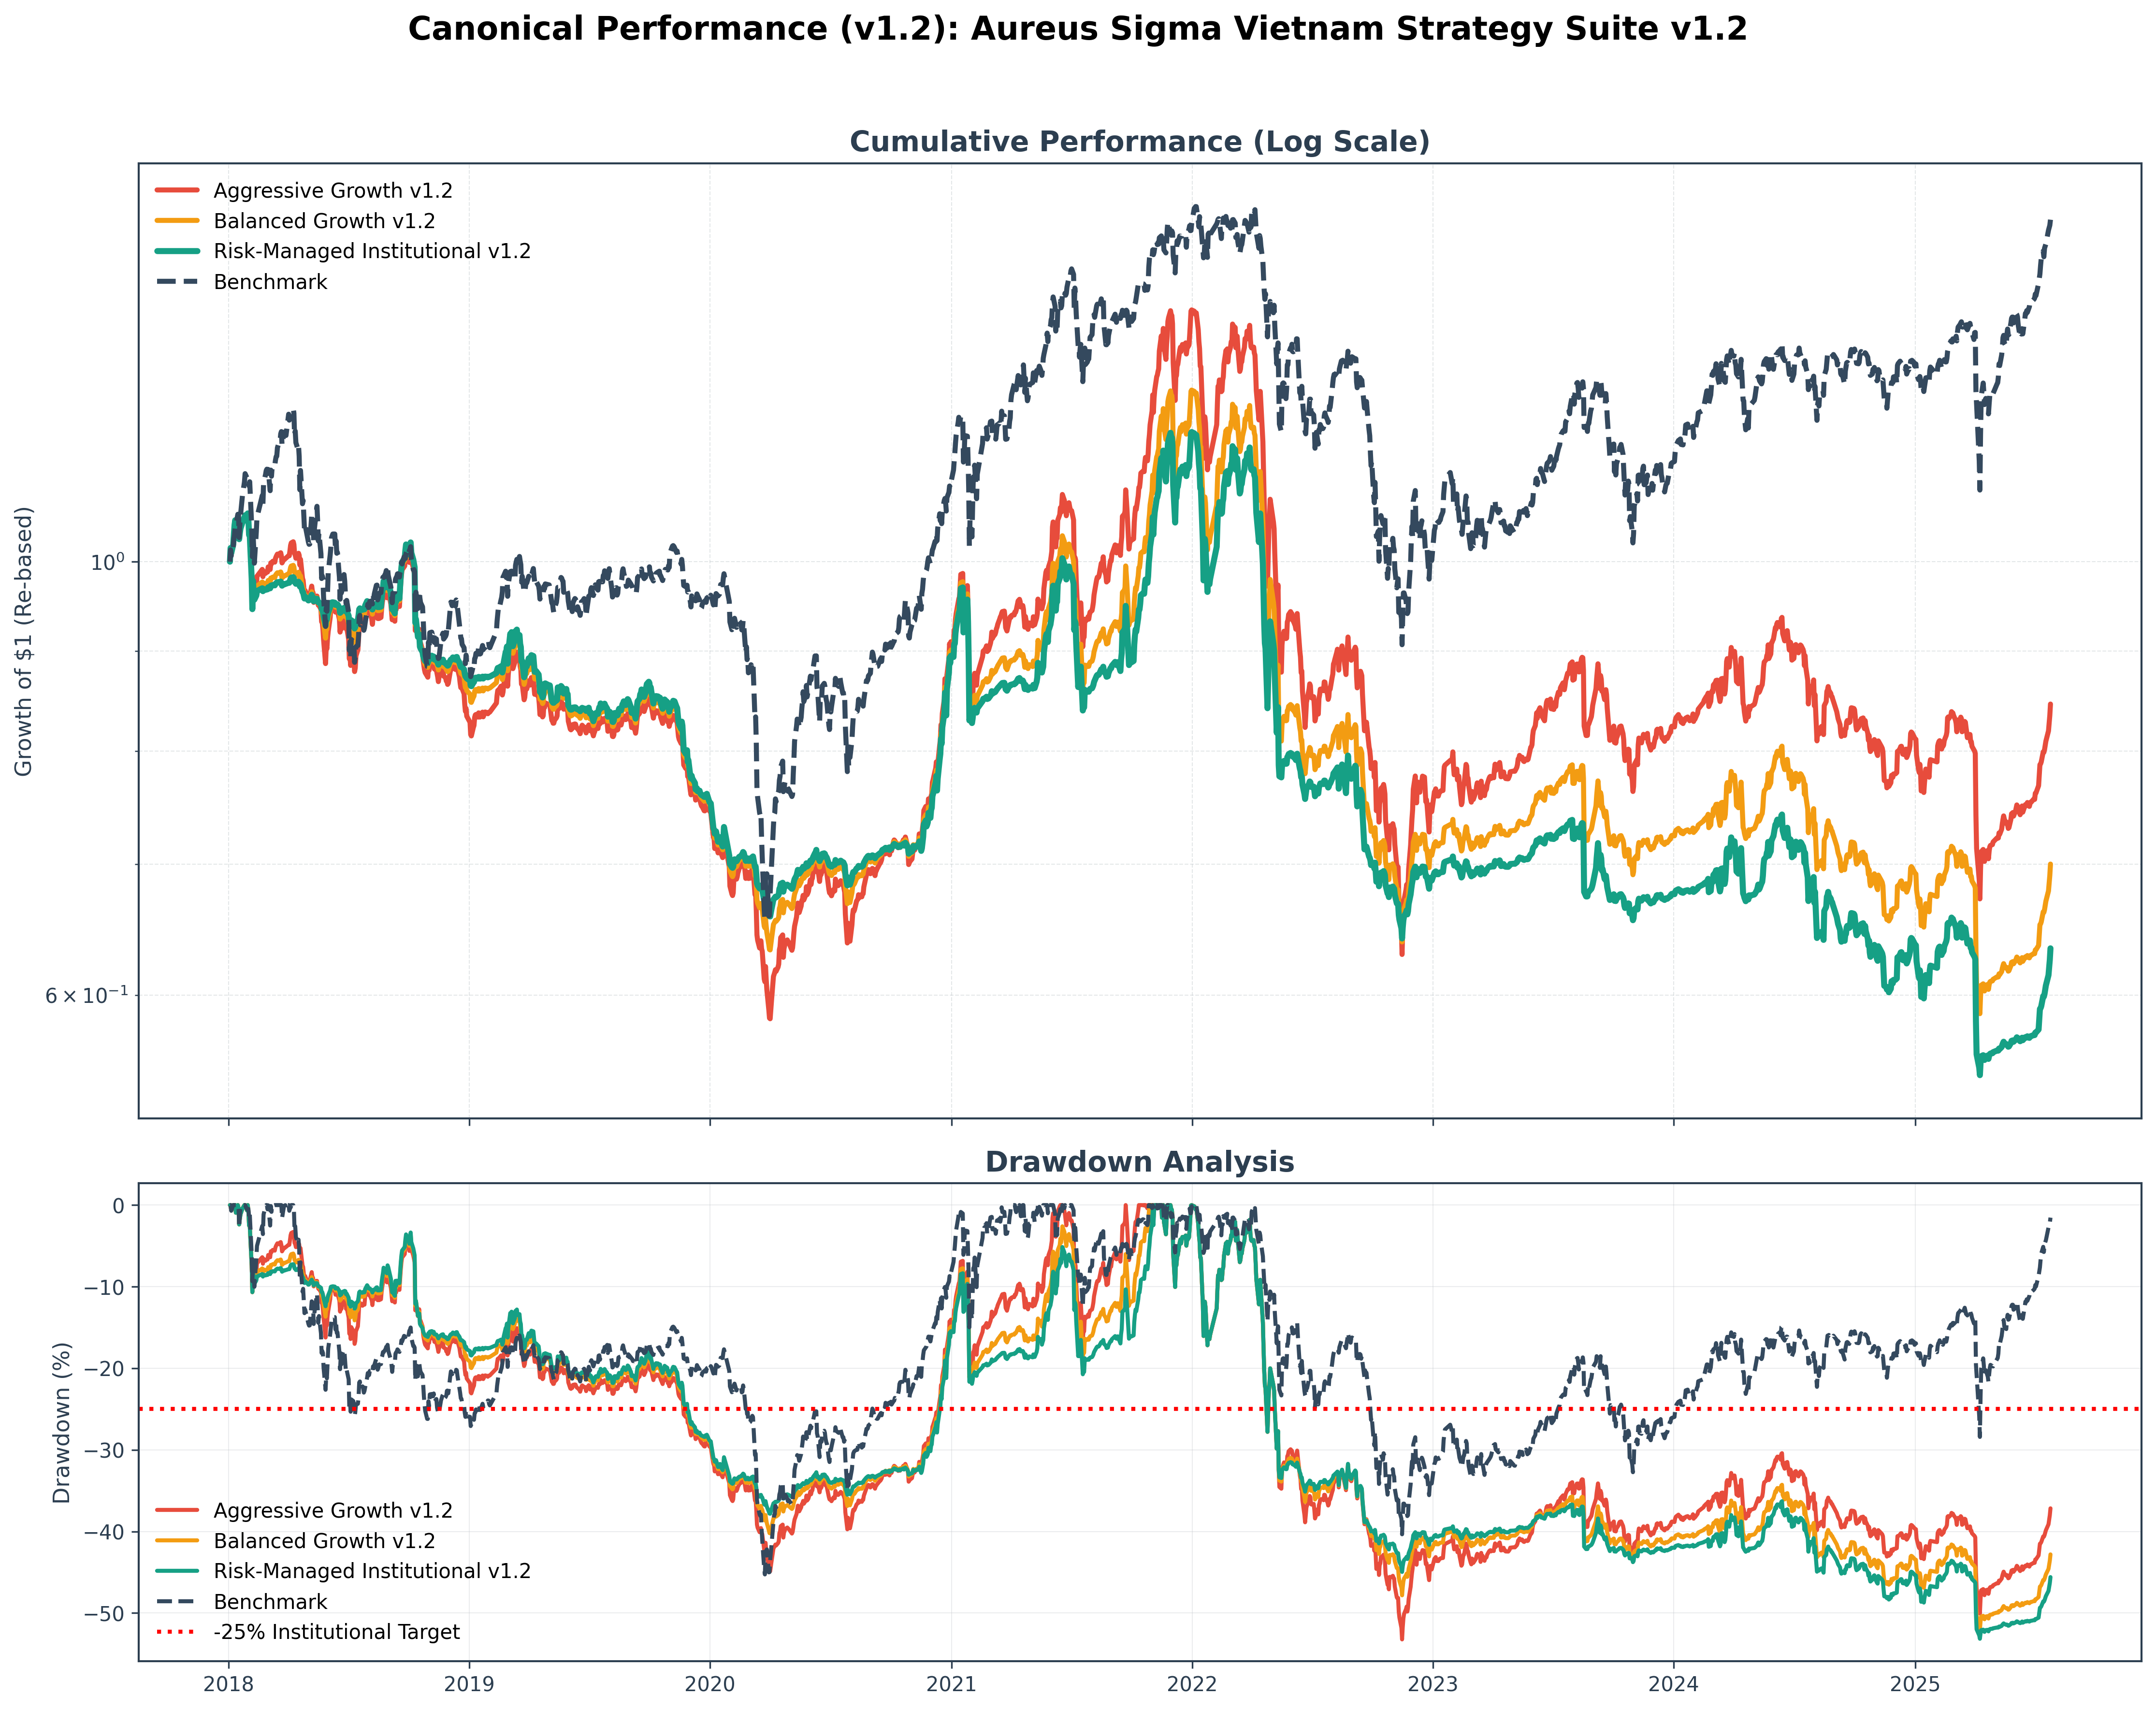


CANONICAL PERFORMANCE SUMMARY (v1.2): 2018-01-03 to 2025-07-25


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Beta,Annual Alpha
Aggressive Growth v1.2,-2.11%,18.22%,-0.12,-53.23%,-0.04,0.76,-6.44%
Balanced Growth v1.2,-4.55%,16.15%,-0.28,-52.06%,-0.09,0.61,-8.01%
Risk-Managed Institutional v1.2,-5.82%,15.44%,-0.38,-53.15%,-0.11,0.53,-8.84%
Benchmark,5.69%,19.62%,0.29,-45.26%,0.13,1.00,0.00%


In [8]:
# ============================================================================
# CELL 5: FINAL PERFORMANCE ANALYSIS AND TEARSHEET (v1.2)
# ============================================================================

print("📊 Generating final performance analysis for the CORRECTED v1.2 Production Strategies...")

# --- 1. Re-base the data for fair comparison ---
strategy_columns_v1_2 = [col for col in returns_df_v1_2.columns if col != 'Benchmark']
true_inception_date_v1_2 = returns_df_v1_2[strategy_columns_v1_2].ne(0).any(axis=1).idxmax()
returns_df_rebased_v1_2 = returns_df_v1_2.loc[true_inception_date_v1_2:].copy()
print(f"   - Performance analysis re-based to true inception date: {true_inception_date_v1_2.date()}")

# --- 2. Define the Final Tearsheet Function ---
def calculate_full_performance_metrics(returns: pd.Series, benchmark: pd.Series) -> Dict[str, float]:
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = ((1 + returns).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0
    benchmark_annual_return = ((1 + benchmark).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    alpha = annual_return - (beta * benchmark_annual_return)
    return {
        'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Annual Alpha': alpha * 100
    }

def create_final_tearsheet_v1_2(returns_df: pd.DataFrame, strategy_name: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'Canonical Performance (v1.2): {strategy_name}', fontsize=16, fontweight='bold')
    
    # --- Plot 1: Cumulative Performance (Re-based) ---
    cumulative_returns = (1 + returns_df).cumprod()
    cumulative_rebased = cumulative_returns.div(cumulative_returns.iloc[0])
    
    for col in cumulative_rebased.columns:
        color_key = col.replace(' v1.2', '').replace(' Institutional', '')
        ax1.plot(cumulative_rebased.index, cumulative_rebased[col], 
                 label=col, color=STRATEGY_COLORS.get(col, STRATEGY_COLORS.get(color_key)), 
                 linestyle=('--' if col == 'Benchmark' else '-'),
                 linewidth=(3 if "Risk-Managed" in col else 2.5))
    ax1.set_yscale('log')
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of $1 (Re-based)')
    ax1.legend(loc='upper left')
    ax1.grid(True, which="both", ls="--", alpha=0.4)

    # --- Plot 2: Drawdown ---
    for col in cumulative_rebased.columns:
        color_key = col.replace(' v1.2', '').replace(' Institutional', '')
        peak = cumulative_rebased[col].expanding(min_periods=1).max()
        drawdown = (cumulative_rebased[col] - peak) / peak
        ax2.plot(drawdown.index, drawdown * 100, label=col, color=STRATEGY_COLORS.get(col, STRATEGY_COLORS.get(color_key)),
                 linestyle=('--' if col == 'Benchmark' else '-'))
    ax2.axhline(-25, color='red', linestyle=':', linewidth=2, label='-25% Institutional Target')
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend(loc='lower left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 3. Generate Tearsheet and Summary Table ---
create_final_tearsheet_v1_2(returns_df_rebased_v1_2, "Aureus Sigma Vietnam Strategy Suite v1.2")

summary_metrics_v1_2 = {name: calculate_full_performance_metrics(returns_df_rebased_v1_2[name], returns_df_rebased_v1_2['Benchmark']) 
                        for name in returns_df_rebased_v1_2.columns}

# Define the desired order for the summary table
strategy_order_v1_2 = [
    "Aggressive Growth v1.2",
    "Balanced Growth v1.2",
    "Risk-Managed Institutional v1.2",
    "Benchmark"
]
summary_df_v1_2 = pd.DataFrame(summary_metrics_v1_2).T.loc[strategy_order_v1_2]

print("\n" + "=" * 80)
print(f"CANONICAL PERFORMANCE SUMMARY (v1.2): {true_inception_date_v1_2.strftime('%Y-%m-%d')} to {ANALYSIS_END_DATE}")
print("=" * 80)
display(summary_df_v1_2.style.format({
    'Annual Return': '{:.2f}%', 'Annual Volatility': '{:.2f}%',
    'Sharpe Ratio': '{:.2f}', 'Max Drawdown': '{:.2f}%',
    'Calmar Ratio': '{:.2f}', 'Beta': '{:.2f}', 'Annual Alpha': '{:.2f}%'
}).background_gradient(cmap='viridis', subset=['Sharpe Ratio', 'Calmar Ratio', 'Annual Alpha']))